<h1>Use Strategy3</h1>
<p>- Dữ liệu nhỏ nhưng khác</p>

In [1]:
!nvidia-smi

Thu Nov 11 09:47:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras import Sequential,Model
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,BatchNormalization,SeparableConv2D,Activation,GlobalAveragePooling2D,Add
from tensorflow.keras import backend as k
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint, ReduceLROnPlateau,LearningRateScheduler,TensorBoard
from tensorflow.keras.layers.experimental.preprocessing import Rescaling,Resizing
import datetime

In [4]:
# Set batch size
#BATCH_SIZE = 8 * strategy.num_replicas_in_sync
BATCH_SIZE = 32

# Set number of epochs
EPOCHS = 500

# Patience for the learning rate
LR_PATIENCE = 5

# Patience for early stopping
STOPPING_PATIENCE = 30

In [5]:
train_directory = '../input/bird-dataset/Bird_DataClassification/Train'
valid_directory = '../input/bird-dataset/Bird_DataClassification/Valid'
test_directory = '../input/bird-dataset/Bird_DataClassification/Test'

In [6]:
import glob
print('Train: parrot - ',len(glob.glob(train_directory+'/0/*')),' || oriole - ',len(glob.glob(train_directory+'/1/*')))
print('Validation: parrot - ',len(glob.glob(valid_directory+'/0/*')),' || oriole - ',len(glob.glob(valid_directory+'/1/*')))
print('Test: parrot - ',len(glob.glob(test_directory+'/0/*')),' || oriole - ',len(glob.glob(test_directory+'/1/*')))

Train: parrot -  1196  || oriole -  814
Validation: parrot -  403  || oriole -  200
Test: parrot -  564  || oriole -  175


In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_directory,seed=123,image_size=(256,256),batch_size=BATCH_SIZE)
# train_datagen = ImageDataGenerator(rescale=1./255,
#                                   horizontal_flip=True,fill_mode='reflect'
#                                   rotation_range=)

Found 2010 files belonging to 2 classes.


2021-11-11 09:47:45.706184: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 09:47:45.818855: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 09:47:45.819948: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-11 09:47:45.823723: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [8]:
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(valid_directory,seed=13,image_size=(256,256),batch_size=BATCH_SIZE)

Found 603 files belonging to 2 classes.


In [9]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_directory,seed=123,image_size=(256,256),batch_size=BATCH_SIZE)

Found 739 files belonging to 2 classes.


2021-11-11 09:47:48.743091: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


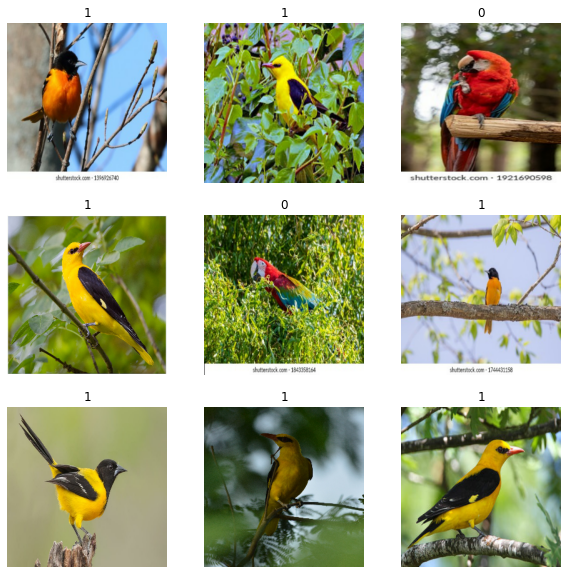

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

<h2>Data Augmentation</h2>

In [11]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
                                         tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
                                         Rescaling(1./ 255)])

In [12]:
train_ds = train_ds.map(lambda x,y: (data_augmentation(x),y))
valid_ds = valid_ds.map(lambda x,y: (data_augmentation(x),y))

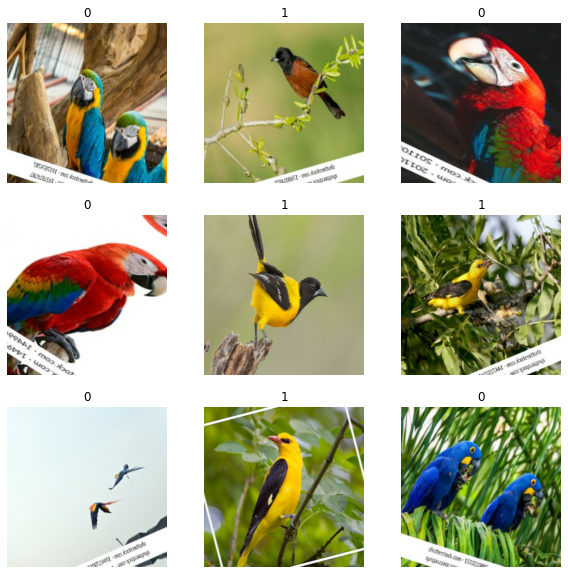

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(int(labels[i]))
        plt.axis("off")

<h2>Build and Train model</h2>

In [14]:
MobileNetV2_model = applications.MobileNetV2(weights='imagenet',include_top = False,input_shape=(256,256,3),input_tensor=None)

9420800/9406464 [==============================] - 0s 0us/step


In [15]:
MobileNetV2_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 128, 128, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [16]:
status = False # Nếu gặp block_4_add thì chuyển status từ False sang True
for layer in MobileNetV2_model.layers:
    layer.trainable = status
    if layer.name == 'block_5_add':
        check = True

In [17]:
def classifier_model(input_shape = (256,256,3), num_classes = 2):
    x = MobileNetV2_model.output
    x = Flatten()(x)
    x = Dense(1024,activation='relu')(x)
    x = Dense(512,activation='relu')(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes
    x= Dropout(0.5)(x)
    outputs = Dense(units,activation=activation)(x)
    return Model(MobileNetV2_model.input,outputs)

In [18]:
classifier2 = classifier_model(input_shape = (256,256,3), num_classes = 2)

In [19]:
classifier2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 128, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 128, 128, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 128, 128, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [20]:
loss = 'binary_crossentropy'
metrics=['accuracy']
classifier2.compile(optimizer='adam',loss=loss,metrics=metrics)

In [21]:
learning_rate = ReduceLROnPlateau(patience=LR_PATIENCE,verbose=1,factor=0.5,min_delta=0.000001)
early_stopping = EarlyStopping(patience=STOPPING_PATIENCE,monitor='val_loss',verbose=1,restore_best_weights=True,mode='min')

In [22]:
t0 = datetime.datetime.now()

In [23]:
history = classifier2.fit(train_ds,validation_data=valid_ds,epochs=EPOCHS,callbacks=[learning_rate,early_stopping])

Epoch 1/500


2021-11-11 09:48:02.106442: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


63/63 [==============================] - 42s 503ms/step - loss: 2.4143 - accuracy: 0.9154 - val_loss: 0.6654 - val_accuracy: 0.9685
Epoch 2/500
63/63 [==============================] - 29s 453ms/step - loss: 0.4036 - accuracy: 0.9682 - val_loss: 1.2605 - val_accuracy: 0.9386
Epoch 3/500
63/63 [==============================] - 29s 443ms/step - loss: 0.3512 - accuracy: 0.9761 - val_loss: 0.4520 - val_accuracy: 0.9619
Epoch 4/500
63/63 [==============================] - 29s 441ms/step - loss: 0.1725 - accuracy: 0.9816 - val_loss: 0.2558 - val_accuracy: 0.9635
Epoch 5/500
63/63 [==============================] - 29s 441ms/step - loss: 0.0810 - accuracy: 0.9851 - val_loss: 0.3494 - val_accuracy: 0.9635
Epoch 6/500
63/63 [==============================] - 29s 450ms/step - loss: 0.1424 - accuracy: 0.9831 - val_loss: 0.4245 - val_accuracy: 0.9668
Epoch 7/500
63/63 [==============================] - 30s 458ms/step - loss: 0.1332 - accuracy: 0.9881 - val_loss: 0.7629 - val_accuracy: 0.9420
Epoc

In [24]:
t1 = datetime.datetime.now()
print('Time training: ',t1-t0)

Time training:  0:45:51.141966


<h2>Evaluation</h2<

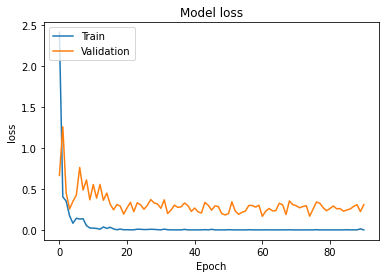

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'],loc='upper left')
plt.show()

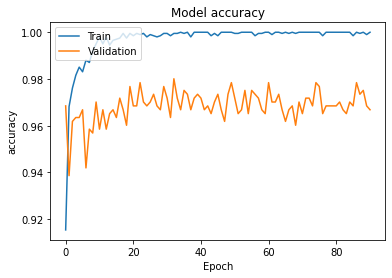

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'],loc='upper left')
plt.show()

In [29]:
classifier2.save('Ex4classifier2.h5')

In [30]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
loadEx4_model = load_model('./Ex4classifier2.h5') 

In [31]:
train_score = loadEx4_model.evaluate(train_ds)

63/63 [==============================] - 23s 336ms/step - loss: 1.2935e-04 - accuracy: 1.0000


In [32]:
valid_score = loadEx4_model.evaluate(valid_ds)

19/19 [==============================] - 7s 310ms/step - loss: 0.3008 - accuracy: 0.9768


In [33]:
test_score = loadEx4_model.evaluate(test_ds)

24/24 [==============================] - 4s 115ms/step - loss: 1.9367 - accuracy: 0.7321


<h2>Nhận xét</h2>
<li>So với model bài 3 thì model bài 4 có độ chính xác cao hơn trên cả tập train và valid. Tuy nhiên trên tập test thì có độ chính xác thấp -> Model bài 4 bị overfitting</li>
<li>So với model bài 3 thì model bài 4 cần thời gian training lâu hơn khoảng 45p (so với bài 3 là 38p)</li>

In [34]:
new_url1 = 'https://sudospaces.com/gaocung-com/2021/01/chim-vang-anh-an-gi-1.jpg'
new_url2 = 'https://cdn.chotot.com/MfxqCZMCgcr-PqIvoOCcmP8VZGqZnWVpfbB_wl59QXM/preset:view/plain/5a0e729ef5c9265889ab6e0a6b86d68d-2745499794937820100.jpg'

In [35]:
f = open("../input/bird-dataset/Bird_DataClassification/info.txt", "r")
print(f.read()) # in ra bảng thông tin nhãn

0,vet
1,chim_vang_anh


In [44]:
from PIL import Image
import requests

def get_imgURL(url): 
    im = Image.open(requests.get(url, stream=True).raw)
    im = im.resize((256,256))
    img_array = np.asarray(im)
    img_array = tf.expand_dims(img_array,0)
    return img_array

In [45]:
img1 = get_imgURL(new_url1)
img1.shape

TensorShape([1, 256, 256, 3])

In [47]:
predictions1 = loadEx4_model.predict(img1)
score1 = predictions1[0]
print("This image is %.2f percent parrot and %.2f percent oriole."% (100 * (1 - score1), 100 * score1))

This image is 100.00 percent parrot and 0.00 percent oriole.


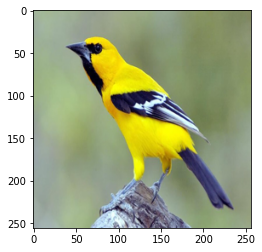

In [48]:
plt.imshow(img1[0]) # oriole

In [49]:
img2 = get_imgURL(new_url2)
img2.shape

TensorShape([1, 256, 256, 3])

In [51]:
predictions2 = loadEx4_model.predict(img2)
score2 = predictions2[0]
print("This image is %.2f percent parrot and %.2f percent oriole."% (100 * (1 - score2), 100 * score2))

This image is 0.00 percent parrot and 100.00 percent oriole.


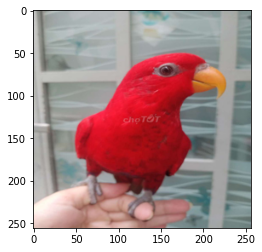

In [52]:
plt.imshow(img2[0]) # parrot

In [53]:
# link notebook: https://www.kaggle.com/hnganhlnguyn/ex4-transferlearning
# Author by Hung Anh